In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
# 
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

from logging import getLogger
import math
import itertools
import numpy as np
import torch
from torch._C import _set_backcompat_keepdim_warn
import torch.nn as nn
import torch.nn.functional as F


N_MAX_POSITIONS = 4096  # maximum input sequence length


logger = getLogger()


def Embedding(num_embeddings, embedding_dim, padding_idx=None):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.normal_(m.weight, mean=0, std=embedding_dim ** -0.5)
    if padding_idx is not None:
        nn.init.constant_(m.weight[padding_idx], 0)
    return m


def create_sinusoidal_embeddings(n_pos, dim, out):
    position_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)]
            for pos in range(n_pos)
        ]
    )
    out[:, 0::2] = torch.FloatTensor(np.sin(position_enc[:, 0::2]))
    out[:, 1::2] = torch.FloatTensor(np.cos(position_enc[:, 1::2]))
    out.detach_()
    out.requires_grad = False


def get_masks(slen, lengths, causal):
    """
    Generate hidden states mask, and optionally an attention mask.
    """
    assert lengths.max().item() <= slen
    bs = lengths.size(0)
    alen = torch.arange(slen, dtype=torch.long, device=lengths.device)
    mask = alen < lengths[:, None]

    # attention mask is the same as mask, or triangular inferior attention (causal)
    if causal:
        attn_mask = alen[None, None, :].repeat(bs, slen, 1) <= alen[None, :, None]
    else:
        attn_mask = mask

    # sanity check
    assert mask.size() == (bs, slen)
    assert causal is False or attn_mask.size() == (bs, slen, slen)

    return mask, attn_mask


class MultiHeadAttention(nn.Module):

    NEW_ID = itertools.count()

    def __init__(self, n_heads, dim, src_dim, dropout):
        super().__init__()
        self.layer_id = next(MultiHeadAttention.NEW_ID)
        self.dim = dim
        self.src_dim = src_dim
        self.n_heads = n_heads
        self.dropout = dropout
        assert self.dim % self.n_heads == 0

        self.q_lin = nn.Linear(dim, dim)
        self.k_lin = nn.Linear(src_dim, dim)
        self.v_lin = nn.Linear(src_dim, dim)
        self.out_lin = nn.Linear(dim, dim)
        
    def forward(self, input, mask, kv=None, use_cache=False):
        """
        Self-attention (if kv is None)
        or attention over source sentence (provided by kv).
        Input is (bs, qlen, dim)
        Mask is (bs, klen) (non-causal) or (bs, klen, klen)
        """
        assert not (use_cache and self.cache is None)
        bs, qlen, dim = input.size()
        if kv is None:
            klen = qlen if not use_cache else self.cache["slen"] + qlen
        else:
            klen = kv.size(1)
        assert dim == self.dim, "Dimensions do not match: %s input vs %s configured" % (
            dim,
            self.dim,
        )
        n_heads = self.n_heads
        dim_per_head = dim // n_heads
        mask_reshape = (bs, 1, qlen, klen) if mask.dim() == 3 else (bs, 1, 1, klen)

        def shape(x):
            """  projection """
            return x.view(bs, -1, self.n_heads, dim_per_head).transpose(1, 2)

        def unshape(x):
            """  compute context """
            return (
                x.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * dim_per_head)
            )

        q = shape(self.q_lin(input))  # (bs, n_heads, qlen, dim_per_head)
        if kv is None:
            k = shape(self.k_lin(input))  # (bs, n_heads, qlen, dim_per_head)
            v = shape(self.v_lin(input))  # (bs, n_heads, qlen, dim_per_head)
        elif not use_cache or self.layer_id not in self.cache:
            k = v = kv
            k = shape(self.k_lin(k))  # (bs, n_heads, qlen, dim_per_head)
            v = shape(self.v_lin(v))  # (bs, n_heads, qlen, dim_per_head)

        if use_cache:
            if self.layer_id in self.cache:
                if kv is None:
                    k_, v_ = self.cache[self.layer_id]
                    k = torch.cat([k_, k], dim=2)  # (bs, n_heads, klen, dim_per_head)
                    v = torch.cat([v_, v], dim=2)  # (bs, n_heads, klen, dim_per_head)
                else:
                    k, v = self.cache[self.layer_id]
            self.cache[self.layer_id] = (k, v)
        q = q / math.sqrt(dim_per_head)  # (bs, n_heads, qlen, dim_per_head)
        scores = torch.matmul(q, k.transpose(2, 3))  # (bs, n_heads, qlen, klen)
        mask = (
            (mask == 0).view(mask_reshape).expand_as(scores)
        )  # (bs, n_heads, qlen, klen)
        scores.masked_fill_(mask, -float("inf"))  # (bs, n_heads, qlen, klen)

        weights = F.softmax(scores.float(), dim=-1).type_as(
            scores
        )  # (bs, n_heads, qlen, klen)
        weights = F.dropout(
            weights, p=self.dropout, training=self.training
        )  # (bs, n_heads, qlen, klen)
        context = torch.matmul(weights, v)  # (bs, n_heads, qlen, dim_per_head)
        context = unshape(context)  # (bs, qlen, dim)

        if TransformerModel.STORE_OUTPUTS and not self.training:
            self.outputs = weights.detach().cpu()

        return self.out_lin(context)


class TransformerFFN(nn.Module):
    def __init__(self, in_dim, dim_hidden, out_dim, dropout):
        super().__init__()
        self.dropout = dropout
        self.act = F.relu
        self.lin1 = nn.Linear(in_dim, dim_hidden)
        self.lin2 = nn.Linear(dim_hidden, out_dim)
    
    def forward(self, input):
        x = self.lin1(input)
        x = self.act(x)
        x = self.lin2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x


class TransformerLayer(nn.Module):
    def __init__(self, params, is_encoder):
        """
        Transformer model (encoder or decoder).
        """
        super().__init__()

        self.is_encoder = is_encoder
        self.is_decoder = not is_encoder

        # model parameters
        self.dim = params.enc_emb_dim if is_encoder else params.dec_emb_dim  # 512 by default
        self.src_dim = params.enc_emb_dim
        self.hidden_dim = self.dim * 4  # 2048 by default
        self.n_heads = params.n_enc_heads if is_encoder else params.n_dec_heads  # 8 by default
        self.n_layers = params.n_enc_layers if is_encoder else params.n_dec_layers
        self.dropout = params.dropout
        self.attention_dropout = params.attention_dropout
        
        assert (
            self.dim % self.n_heads == 0
        ), "transformer dim must be a multiple of n_heads"
        self.self_attention = MultiHeadAttention(
            self.n_heads,
            self.dim,
            self.dim,
            dropout=self.attention_dropout,
        )
        self.layer_norm1 = nn.LayerNorm(self.dim, eps=1e-12)
        if self.is_decoder:
            self.layer_norm15 = nn.LayerNorm(self.dim, eps=1e-12)
            self.cross_attention = MultiHeadAttention(
                self.n_heads,
                self.dim,
                self.src_dim,
                dropout=self.attention_dropout,
            )
        self.ffn = TransformerFFN(
            self.dim,
            self.hidden_dim,
            self.dim,
            dropout=self.dropout,
        )
        self.layer_norm2 = nn.LayerNorm(self.dim, eps=1e-12)

    def forward(self, x, attn_mask, src_mask, src_enc, use_cache=False, cache=None):
        tensor = x
        # self attention
        self.self_attention.cache = cache
        attn = self.self_attention(tensor, attn_mask, use_cache=use_cache)
        attn = F.dropout(attn, p=self.dropout, training=self.training)
        output = tensor + attn
        output = self.layer_norm1(output)

        # encoder attention (for decoder only)
        if self.is_decoder and src_enc is not None:
            self.cross_attention.cache = cache
            attn = self.cross_attention(tensor, src_mask, kv=src_enc, use_cache=use_cache)
            attn = F.dropout(attn, p=self.dropout, training=self.training)
            output = output + attn
            output = self.layer_norm15(output)

        # FFN
        output = output + self.ffn(output)
        tensor = self.layer_norm2(output)
        return tensor


class TransformerModel(nn.Module):

    STORE_OUTPUTS = False

    def __init__(self, params, id2word, is_encoder, with_output):
        """
        Transformer model (encoder or decoder).
        """
        super().__init__()

        # encoder / decoder, output layer
        self.dtype = torch.half if params.fp16 else torch.float
        self.is_encoder = is_encoder
        self.is_decoder = not is_encoder
        self.with_output = with_output

        # dictionary
        self.n_words = params.n_words
        self.eos_index = params.eos_index
        self.pad_index = params.pad_index
        self.id2word = id2word
        assert len(self.id2word) == self.n_words

        # model parameters
        self.dim = params.enc_emb_dim if is_encoder else params.dec_emb_dim  # 512 by default
        self.src_dim = params.enc_emb_dim
        self.hidden_dim = self.dim * 4  # 2048 by default
        self.n_heads = params.n_enc_heads if is_encoder else params.n_dec_heads  # 8 by default
        self.n_layers = params.n_enc_layers if is_encoder else params.n_dec_layers
        self.dropout = params.dropout
        self.attention_dropout = params.attention_dropout
        assert (
            self.dim % self.n_heads == 0
        ), "transformer dim must be a multiple of n_heads"
        
        # embeddings
        self.position_embeddings = Embedding(N_MAX_POSITIONS, self.dim)
        if params.sinusoidal_embeddings:
            create_sinusoidal_embeddings(
                N_MAX_POSITIONS, self.dim, out=self.position_embeddings.weight
            )
        self.embeddings = Embedding(self.n_words, self.dim, padding_idx=self.pad_index)
        self.layer_norm_emb = nn.LayerNorm(self.dim, eps=1e-12)

        # transformer layers
        self.layers = nn.ModuleList()
        for layer_id in range(self.n_layers):
            self.layers.append(TransformerLayer(params, self.is_encoder))

        self.cache = None

        # output layer
        if self.with_output:
            self.proj = nn.Linear(self.dim, params.n_words, bias=True)
            if params.share_inout_emb:
                self.proj.weight = self.embeddings.weight

    def forward(self, mode, **kwargs):
        """
        Forward function with different forward modes.
        ### Small hack to handle PyTorch distributed.
        """
        if mode == "fwd":
            return self.fwd(**kwargs)
        elif mode == "predict":
            return self.predict(**kwargs)
        else:
            raise Exception("Unknown mode: %s" % mode)

    def fwd(
        self,
        x,
        lengths,
        causal,
        src_enc=None,
        src_len=None,
        positions=None,
        use_cache=False,
    ):
        """
        Inputs:
            `x` LongTensor(slen, bs), containing word indices
            `lengths` LongTensor(bs), containing the length of each sentence
            `causal` Boolean, if True, the attention is only done over previous hidden states
            `positions` LongTensor(slen, bs), containing word positions
        """
        # lengths = (x != self.pad_index).float().sum(dim=1)
        # mask = x != self.pad_index

        # check inputs
        slen, bs = x.size()
        assert lengths.size(0) == bs
        assert lengths.max().item() <= slen
        x = x.transpose(0, 1)  # batch size as dimension 0
        assert (src_enc is None) == (src_len is None)
        if src_enc is not None:
            assert self.is_decoder
            assert src_enc.size(0) == bs
        assert not (use_cache and self.cache is None)

        # generate masks
        mask, attn_mask = get_masks(slen, lengths, causal)
        src_mask = None
        if self.is_decoder and src_enc is not None:
            src_mask = (
                torch.arange(src_len.max(), dtype=torch.long, device=lengths.device)
                < src_len[:, None]
            )
        
        # positions
        if positions is None:
            positions = x.new(slen).long()
            positions = torch.arange(slen, out=positions).unsqueeze(0)
        else:
            assert positions.size() == (slen, bs)
            positions = positions.transpose(0, 1)

        # do not recompute cached elements
        if use_cache:
            _slen = slen - self.cache["slen"]
            x = x[:, -_slen:]
            positions = positions[:, -_slen:]
            mask = mask[:, -_slen:]
            attn_mask = attn_mask[:, -_slen:]

        # all layer outputs
        if TransformerModel.STORE_OUTPUTS and not self.training:
            self.outputs = []

        # embeddings
        tensor = self.embeddings(x)
        tensor = tensor + self.position_embeddings(positions).expand_as(tensor)
        tensor = self.layer_norm_emb(tensor)
        tensor = F.dropout(tensor, p=self.dropout, training=self.training)
        tensor *= mask.unsqueeze(-1).to(tensor.dtype)
        if TransformerModel.STORE_OUTPUTS and not self.training:
            self.outputs.append(tensor.detach().cpu())

        # transformer layers
        for i in range(self.n_layers):
            tensor = self.layers[i].forward(tensor, attn_mask, src_mask, src_enc, use_cache=use_cache, cache=self.cache)
    
            tensor *= mask.unsqueeze(-1).to(tensor.dtype)
            if TransformerModel.STORE_OUTPUTS and not self.training:
                self.outputs.append(tensor.detach().cpu())

        # update cache length
        if use_cache:
            self.cache["slen"] += tensor.size(1)

        # move back sequence length to dimension 0
        tensor = tensor.transpose(0, 1)

        return tensor

    def predict(self, tensor, pred_mask, y, get_scores):
        """
        Given the last hidden state, compute word scores and/or the loss.
            `pred_mask` is a ByteTensor of shape (slen, bs), filled with 1 when
                we need to predict a word
            `y` is a LongTensor of shape (pred_mask.sum(),)
            `get_scores` is a boolean specifying whether we need to return scores
        """
        x = tensor[pred_mask.unsqueeze(-1).expand_as(tensor)].view(-1, self.dim)
        assert (y == self.pad_index).sum().item() == 0
        scores = self.proj(x).view(-1, self.n_words)
        loss = F.cross_entropy(scores.float(), y, reduction="mean")
        return scores, loss

    def generate(self, src_enc, src_len, max_len=200, sample_temperature=None):
        """
        Decode a sentence given initial start.
        `x`:
            - LongTensor(bs, slen)
                <EOS> W1 W2 W3 <EOS> <PAD>
                <EOS> W1 W2 W3   W4  <EOS>
        `lengths`:
            - LongTensor(bs) [5, 6]
        `positions`:
            - False, for regular "arange" positions (LM)
            - True, to reset positions from the new generation (MT)
        """

        # input batch
        bs = len(src_len)
        assert src_enc.size(0) == bs

        # generated sentences
        generated = src_len.new(max_len, bs)  # upcoming output
        generated.fill_(self.pad_index)  # fill upcoming ouput with <PAD>
        generated[0].fill_(self.eos_index)  # we use <EOS> for <BOS> everywhere

        # positions
        positions = src_len.new(max_len).long()
        positions = (
            torch.arange(max_len, out=positions).unsqueeze(1).expand_as(generated)
        )

        # current position / max lengths / length of generated sentences / unfinished sentences
        cur_len = 1
        gen_len = src_len.clone().fill_(1)
        unfinished_sents = src_len.clone().fill_(1)

        # cache compute states
        self.cache = {"slen": 0}

        while cur_len < max_len:

            # compute word scores
            tensor = self.forward(
                "fwd",
                x=generated[:cur_len],
                lengths=gen_len,
                positions=positions[:cur_len],
                causal=True,
                src_enc=src_enc,
                src_len=src_len,
                use_cache=True,
            )
            assert tensor.size() == (1, bs, self.dim)
            tensor = tensor.data[-1, :, :] # .to(self.dtype)  # (bs, dim)
            scores = self.proj(tensor)  # (bs, n_words)

            # select next words: sample or greedy
            if sample_temperature is None:
                next_words = torch.topk(scores, 1)[1].squeeze(1)
            else:
                next_words = torch.multinomial(
                    F.softmax(scores.float() / sample_temperature, dim=1), 1
                ).squeeze(1)
            assert next_words.size() == (bs,)

            # update generations / lengths / finished sentences / current length
            generated[cur_len] = next_words * unfinished_sents + self.pad_index * (
                1 - unfinished_sents
            )
            gen_len.add_(unfinished_sents)
            unfinished_sents.mul_(next_words.ne(self.eos_index).long())
            cur_len = cur_len + 1

            # stop when there is a </s> in each sentence, or if we exceed the maximal length
            if unfinished_sents.max() == 0:
                break

        # add <EOS> to unfinished sentences
        if cur_len == max_len:
            generated[-1].masked_fill_(unfinished_sents.byte(), self.eos_index)

        # sanity check
        assert (generated == self.eos_index).sum() == 2 * bs

        return generated[:cur_len], gen_len

    def generate_beam(
        self, src_enc, src_len, beam_size, length_penalty, early_stopping, max_len=200
    ):
        """
        Decode a sentence given initial start.
        `x`:
            - LongTensor(bs, slen)
                <EOS> W1 W2 W3 <EOS> <PAD>
                <EOS> W1 W2 W3   W4  <EOS>
        `lengths`:
            - LongTensor(bs) [5, 6]
        `positions`:
            - False, for regular "arange" positions (LM)
            - True, to reset positions from the new generation (MT)
        """

        # check inputs
        assert src_enc.size(0) == src_len.size(0)
        assert beam_size >= 1

        # batch size / number of words
        bs = len(src_len)
        n_words = self.n_words

        # expand to beam size the source latent representations / source lengths
        src_enc = (
            src_enc.unsqueeze(1)
            .expand((bs, beam_size) + src_enc.shape[1:])
            .contiguous()
            .view((bs * beam_size,) + src_enc.shape[1:])
        )
        src_len = src_len.unsqueeze(1).expand(bs, beam_size).contiguous().view(-1)

        # generated sentences (batch with beam current hypotheses)
        generated = src_len.new(max_len, bs * beam_size)  # upcoming output
        generated.fill_(self.pad_index)  # fill upcoming ouput with <PAD>
        generated[0].fill_(self.eos_index)  # we use <EOS> for <BOS> everywhere

        # generated hypotheses
        generated_hyps = [
            BeamHypotheses(beam_size, max_len, length_penalty, early_stopping)
            for _ in range(bs)
        ]

        # positions
        positions = src_len.new(max_len).long()
        positions = (
            torch.arange(max_len, out=positions).unsqueeze(1).expand_as(generated)
        )

        # scores for each sentence in the beam
        beam_scores = src_enc.new(bs, beam_size).float().fill_(0)
        beam_scores[:, 1:] = -1e9
        beam_scores = beam_scores.view(-1)

        # current position
        cur_len = 1

        # cache compute states
        self.cache = {"slen": 0}

        # done sentences
        done = [False for _ in range(bs)]

        while cur_len < max_len:

            # compute word scores
            tensor = self.forward(
                "fwd",
                x=generated[:cur_len],
                lengths=src_len.new(bs * beam_size).fill_(cur_len),
                positions=positions[:cur_len],
                causal=True,
                src_enc=src_enc,
                src_len=src_len,
                use_cache=True,
            )

            assert tensor.size() == (1, bs * beam_size, self.dim)
            tensor = tensor.data[-1, :, :]  # .to(self.dtype)  # (bs * beam_size, dim)
            scores = self.proj(tensor)  # (bs * beam_size, n_words)
            scores = F.log_softmax(scores.float(), dim=-1)  # (bs * beam_size, n_words)
            assert scores.size() == (bs * beam_size, n_words)

            # select next words with scores
            _scores = scores + beam_scores[:, None].expand_as(
                scores
            )  # (bs * beam_size, n_words)
            _scores = _scores.view(bs, beam_size * n_words)  # (bs, beam_size * n_words)

            next_scores, next_words = torch.topk(
                _scores, 2 * beam_size, dim=1, largest=True, sorted=True
            )
            assert next_scores.size() == next_words.size() == (bs, 2 * beam_size)

            # next batch beam content
            # list of (bs * beam_size) tuple(next hypothesis score, next word, current position in the batch)
            next_batch_beam = []

            # for each sentence
            for sent_id in range(bs):

                # if we are done with this sentence
                done[sent_id] = done[sent_id] or generated_hyps[sent_id].is_done(
                    next_scores[sent_id].max().item()
                )
                if done[sent_id]:
                    next_batch_beam.extend(
                        [(0, self.pad_index, 0)] * beam_size
                    )  # pad the batch
                    continue

                # next sentence beam content
                next_sent_beam = []

                # next words for this sentence
                for idx, value in zip(next_words[sent_id], next_scores[sent_id]):

                    # get beam and word IDs
                    beam_id = idx // n_words
                    word_id = idx % n_words

                    # end of sentence, or next word
                    if word_id == self.eos_index or cur_len + 1 == max_len:
                        generated_hyps[sent_id].add(
                            generated[:cur_len, sent_id * beam_size + beam_id]
                            .clone()
                            .cpu(),
                            value.item(),
                        )
                    else:
                        next_sent_beam.append(
                            (value, word_id, sent_id * beam_size + beam_id)
                        )

                    # the beam for next step is full
                    if len(next_sent_beam) == beam_size:
                        break

                # update next beam content
                assert len(next_sent_beam) == 0 if cur_len + 1 == max_len else beam_size
                if len(next_sent_beam) == 0:
                    next_sent_beam = [
                        (0, self.pad_index, 0)
                    ] * beam_size  # pad the batch
                next_batch_beam.extend(next_sent_beam)
                assert len(next_batch_beam) == beam_size * (sent_id + 1)

            # sanity check / prepare next batch
            assert len(next_batch_beam) == bs * beam_size
            beam_scores = beam_scores.new([x[0] for x in next_batch_beam])
            beam_words = generated.new([x[1] for x in next_batch_beam])
            beam_idx = src_len.new([x[2] for x in next_batch_beam])

            # re-order batch and internal states
            generated = generated[:, beam_idx]
            generated[cur_len] = beam_words
            for k in self.cache.keys():
                if k != "slen":
                    self.cache[k] = (
                        self.cache[k][0][beam_idx],
                        self.cache[k][1][beam_idx],
                    )

            # update current length
            cur_len = cur_len + 1

            # stop when we are done with each sentence
            if all(done):
                break

        # def get_coeffs(s):
        #     roots = [int(s[i + 2]) for i, c in enumerate(s) if c == 'x']
        #     poly = np.poly1d(roots, r=True)
        #     coeffs = list(poly.coefficients.astype(np.int64))
        #     return [c % 10 for c in coeffs], coeffs

        # visualize hypotheses
        # print([len(x) for x in generated_hyps], cur_len)
        # globals().update( locals() );
        # !import code; code.interact(local=vars())
        # for ii in range(bs):
        #     for ss, ww in sorted(generated_hyps[ii].hyp, key=lambda x: x[0], reverse=True):
        #         hh = " ".join(self.id2word[x] for x in ww.tolist())
        #         print(f"{ss:+.4f} {hh}")
        #         # cc = get_coeffs(hh[4:])
        #         # print(f"{ss:+.4f} {hh} || {cc[0]} || {cc[1]}")
        #     print("")

        # select the best hypotheses
        tgt_len = src_len.new(bs)
        best = []

        for i, hypotheses in enumerate(generated_hyps):
            best_hyp = max(hypotheses.hyp, key=lambda x: x[0])[1]
            tgt_len[i] = len(best_hyp) + 1  # +1 for the <EOS> symbol
            best.append(best_hyp)

        # generate target batch
        decoded = src_len.new(tgt_len.max().item(), bs).fill_(self.pad_index)
        for i, hypo in enumerate(best):
            decoded[: tgt_len[i] - 1, i] = hypo
            decoded[tgt_len[i] - 1, i] = self.eos_index

        # sanity check
        assert (decoded == self.eos_index).sum() == 2 * bs

        return decoded, tgt_len, generated_hyps


class BeamHypotheses(object):
    def __init__(self, n_hyp, max_len, length_penalty, early_stopping):
        """
        Initialize n-best list of hypotheses.
        """
        self.max_len = max_len - 1  # ignoring <BOS>
        self.length_penalty = length_penalty
        self.early_stopping = early_stopping
        self.n_hyp = n_hyp
        self.hyp = []
        self.worst_score = 1e9

    def __len__(self):
        """
        Number of hypotheses in the list.
        """
        return len(self.hyp)

    def add(self, hyp, sum_logprobs):
        """
        Add a new hypothesis to the list.
        """
        score = sum_logprobs / len(hyp) ** self.length_penalty
        if len(self) < self.n_hyp or score > self.worst_score:
            self.hyp.append((score, hyp))
            if len(self) > self.n_hyp:
                sorted_scores = sorted(
                    [(s, idx) for idx, (s, _) in enumerate(self.hyp)]
                )
                del self.hyp[sorted_scores[0][1]]
                self.worst_score = sorted_scores[1][0]
            else:
                self.worst_score = min(score, self.worst_score)

    def is_done(self, best_sum_logprobs):
        """
        If there are enough hypotheses and that none of the hypotheses being generated
        can become better than the worst one in the heap,
        then we are done with this sentence.
        """
        if len(self) < self.n_hyp:
            return False
        elif self.early_stopping:
            return True
        else:
            return (
                self.worst_score
                >= best_sum_logprobs / self.max_len ** self.length_penalty
            )


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [3]:
from PIL import Image
import struct
import matplotlib.pyplot as plt

In [5]:
l_box = (80, 0, 1280, 720)
l_img = Image.open(f"1L.png").convert("RGB").crop(l_box).resize((224, 224))

In [13]:
img = np.array(l_img)/255.0

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def patchify_image(image, patch_size):
    """
    Function to patchify an input image.

    Args:
    - image_path (str): Path to the input image.
    - patch_size (int): Size of each patch.

    Returns:
    - patches (np.array): Patchified image in the shape of (num_patches, patch_size, patch_size, channels).
    - num_patches (int): Number of patches.
    """
    img_height, img_width, _ = image.shape

    # Calculate number of patches in height and width
    num_patches_h = img_height // patch_size
    num_patches_w = img_width // patch_size

    # Crop the image to fit an integer number of patches
    image = image[:num_patches_h * patch_size, :num_patches_w * patch_size, :]

    # Reshape image into patches
    patches = np.reshape(image, (num_patches_h, patch_size, num_patches_w, patch_size, -1))
    patches = np.transpose(patches, (0, 2, 1, 3, 4))
    patches = np.reshape(patches, (-1, patch_size, patch_size, img.shape[2]))

    return patches, num_patches_h * num_patches_w

# Example usage:
#image_path = 'example_image.jpg'
#patch_size = 32  # Choose appropriate patch size
patches, num_patches = patchify_image(img, patch_size)
print("Number of patches:", num_patches)
print("Shape of patches:", patches.shape)


Number of patches: 49
Shape of patches: (49, 32, 32, 3)


In [25]:
patches[0]

array([[[0.16470588, 0.15294118, 0.16862745],
        [0.17647059, 0.16470588, 0.18039216],
        [0.16862745, 0.16078431, 0.17254902],
        ...,
        [0.20784314, 0.19215686, 0.20392157],
        [0.21568627, 0.2       , 0.21568627],
        [0.21960784, 0.20784314, 0.21960784]],

       [[0.15686275, 0.14901961, 0.16470588],
        [0.16078431, 0.14901961, 0.16470588],
        [0.16470588, 0.15294118, 0.16862745],
        ...,
        [0.21568627, 0.20392157, 0.21568627],
        [0.21960784, 0.20392157, 0.21960784],
        [0.22745098, 0.21176471, 0.23137255]],

       [[0.16862745, 0.16078431, 0.17254902],
        [0.16470588, 0.15294118, 0.16862745],
        [0.16078431, 0.14901961, 0.16470588],
        ...,
        [0.21568627, 0.2       , 0.21568627],
        [0.20784314, 0.19215686, 0.20784314],
        [0.21568627, 0.20392157, 0.21568627]],

       ...,

       [[0.18039216, 0.17254902, 0.18431373],
        [0.18431373, 0.17647059, 0.18823529],
        [0.18431373, 0

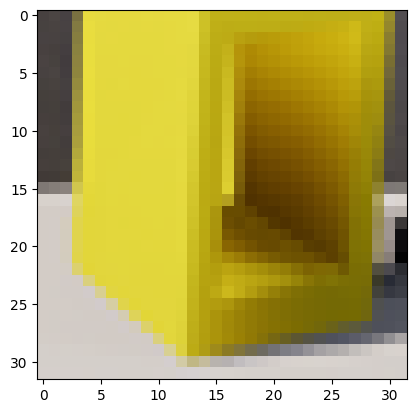

In [34]:
plt.imshow(patches[18])

In [ ]:
def patchify_image_3d(image_data, patch_size):
    """
    Function to patchify a 3D array of image data.

    Args:
    - image_data (np.array): Input image data of shape (W, H, D).
    - patch_size (int): Size of each patch.

    Returns:
    - patches (np.array): Patchified image in the shape of (num_patches, patch_size, patch_size, D).
    - num_patches (int): Number of patches.
    """
    img_height, img_width, num_channels = image_data.shape

    # Calculate number of patches in height and width
    num_patches_h = img_height // patch_size
    num_patches_w = img_width // patch_size

    # Crop the image to fit an integer number of patches
    image_data = image_data[:num_patches_h * patch_size, :num_patches_w * patch_size, :]

    # Reshape image into patches
    patches = np.reshape(image_data, (num_patches_h, patch_size, num_patches_w, patch_size, num_channels))
    patches = np.transpose(patches, (0, 2, 1, 3, 4))
    patches = np.reshape(patches, (-1, patch_size, patch_size, num_channels))

    return patches, num_patches_h * num_patches_w

# Example usage:
# Assuming you have a 3D array called 'image_data'
image_data = np.random.rand(256, 256, 3)  # Example random image data
patch_size = 32  # Choose appropriate patch size
patches, num_patches = patchify_image_3d(image_data, patch_size)
print("Number of patches:", num_patches)
print("Shape of patches:", patches.shape)